# Preparations


In [222]:
import keras
keras.__version__

'2.11.0'

# Promoter region classification

Promoter region prediction is an important part to understand the transcription process. In this lab we'll take a look at a simple way of training a recurrent neural network to solve this task. We'll take the approach from the [DeePromoter](https://www.frontiersin.org/journals/genetics/articles/10.3389/fgene.2019.00286/full) model using data from the implementation [here](https://github.com/egochao/DeePromoter).

The goal here is to see how we can easily use recurrent neural networks to classify sequences.


## The dataset
The dataset is made up known promoter regions from two different species; human and mouse. The regions are 300 base pairs long, and were extracted from $-249 \sim +50$ base pairs (where $+1$ refers to the Transcription Start Site). For each species, two subset of promoter regions were created; those with TATA motifs and those without. This results in four different datasets of positive promoter regions.



## Running on colab
You can use this [link](https://colab.research.google.com/github/NBISweden/workshop-neural-nets-and-deep-learning/blob/rnn_labs/session_recurrentNeuralNetworks/lab_promoterprediction/promoter_prediction.ipynb) to run the notebook on Google Colab. If you do so, it's advised that you first make a copy to your own Google Drive before starting you work on the notebbok. Otherwise changes you make to the notebook will not be saved.

In [223]:
# Run this cell if you don't have the data and you are running the notebook on colab. It'll download it from github and exctract it to the current directory.
from pathlib import Path
data_directory = Path('data')
archive_file = data_directory / 'deepromoter_data.zip'

data_url = "https://github.com/NBISweden/workshop-neural-nets-and-deep-learning/raw/rnn_labs/session_recurrentNeuralNetworks/lab_promoterprediction/data/deepromoter_data.zip"

if not data_directory.exists():
    data_directory.mkdir(parents=True)
    
if not archive_file.exists():
    from urllib.request import urlretrieve
    urlretrieve(data_url, archive_file)
    
if archive_file.exists():
    import zipfile
    with zipfile.ZipFile(archive_file) as zf:
        zf.extractall(data_directory)        


In [224]:
from pathlib import Path
from collections import defaultdict

data_directory = Path('data')
species = ['human', 'mouse']
promoter_type = ['TATA', 'nonTATA']

# To train the model on different datasets, you can change this to use 'mouse' or 'human' 
# for the species and 'TATA' or 'nonTATA' for the promoter type
selected_species = 'mouse'
selected_promoter_type = 'TATA'
selected_dataset_path = data_directory / selected_species / selected_promoter_type

selected_sequences = []
for sequence_file in selected_dataset_path.glob('*.txt'):
    with open(sequence_file) as fp:
        sequences = [line.strip() for line in fp]
        selected_sequences.extend(sequences)

## The negative dataset

To create negative sequences we will use the same method as in the DeePromoter paper, illustrated here:

<div style="display: flex; justify-content: center;">
    <img src="images/negative_generation.jpg" width="600"/>
</div>

The idea is that hard negative examples are introduced by essentially randomly subsituting parts of the positive sequences. We will create as many negative sequences as we have positive ones.

In [225]:
import math
import numpy as np

ALPHABET= np.array(["A", "C", "G", "T"])

def generate_negative_sequence(sequence, chunksize=15, shuffle_ratio=0.6, rng: np.random.Generator = None):
    if rng is None:
        rng = np.random.default_rng()
    
    # The sequences are strings, which doesnt allow for assignment. 
    # We convert it to a list first to to the assignment, then 
    # convert it back to a string in the end
    mutable_sequence = np.array(list(sequence))
    n_chunks = int(math.ceil(len(mutable_sequence)/chunksize))
    n_replaced_chunks = int(math.ceil(n_chunks*shuffle_ratio))
    selected_chunks = rng.choice(n_chunks, size=n_replaced_chunks, replace=False)
    for i in selected_chunks:
        start = i*chunksize
        end = start + chunksize
        chunk = mutable_sequence[start:end]
        # We don't want to rely on just taking the chunksize below, since this 
        # chunk might be the last one and thus not fully chunksize long if the 
        # sequence length isnt divisible with chunksize
        random_chunk = rng.choice(ALPHABET, size=len(chunk), replace=True)
        mutable_sequence[start:end] = random_chunk
    negative_sequence = ''.join(mutable_sequence.tolist())
    return negative_sequence
        

In [226]:
test_sequence = selected_sequences[0]
print("Promoter seqeunce", test_sequence)
negative_sequence = generate_negative_sequence(test_sequence)
print("Negative seqeunce", negative_sequence)

Promoter seqeunce AAAAAGAAAAATGCTTTTCAAAATTCTTATAGAATCACAAATTTCATGAAGGAGGGGGACACACACACATACAGCCTGTGAAGGAGAGAGGATATATGGAAGGAGAGAGGTAAAGAGGAAGTATATCTTAAGATCAAGTTTCACATAATGCCAGATATATTAGCATATACTGGTAGGATTATCTTTTCCCCGCCTACAAATAGCCTAAGCACCCTCCAGTCATAAAAATCAGAGAGAAGTAAGCTGAACAGCAGACACTCCTCCTTACTTCCCACCTCAGAGCAGCTGCATGACTTCCTG
Negative seqeunce CTGTCTTCCGTCTTCCTTGGACGAAAACCGGATATATATACAGCTATGAAGGAGGGGGACACACACACATACAGCTCCTGCTCTCCCTGGGATATATGGAAGGAGACTGTTTAATAAGCCGTATATCTTAAGATCTGGGCCTAAGTGGGCGTAGTTCTTTGACTCTATACTGGTAGGATTCGCTATCCGATTTAGACAAATAGCCTAAGCAATAAAGCCATCAGAGAAAGTTACGATTTTGGCTACGTAACGAGAATGGGGCTCCCTGATCCCACCTCAGAGCAGCTGCATGACTTCCTG


## Creating a promoter dataset
As in the language modelling lab, we will now create a keras `Sequence` class to handle the loading of data. We will reuse much of the code from the previous lab when it comes to encoding the data into integers suitable of ingestion into a neural network. A difference here is that we will train the model for classification, so the dataset will generate batches where the inputs are the sequences, and the target is a binary variable indicating whether it's a promoter region or a negative example.

Also since the vocabulary is known and very constrained beforehand. We will not be using an additional `<UNK>` token. If there are any unknown nucleotides not denoted with an 'N' it's an error. We will still use an plug in tokenizer, there might be cases where the user might want to use some larger motifs as the basic token unit.

We will create the negative sequences inside the dataset, so that this is transparently done.

In [227]:
from keras.utils import Sequence, pad_sequences
from collections import Counter # We will use a counter to keep track of which tokens are the most common
import numpy 


def character_tokenizer(text):
    return list(text)

class PromoterSequenceDataset(Sequence):
    def __init__(self, positive_sequences, batch_size, tokenizer=character_tokenizer, rng=None) -> None:
        super().__init__()
        if rng is None:
            rng = numpy.random.default_rng()
        self.rng = rng
                
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        
        self.positive_sequences = positive_sequences
        self.negative_sequences = [generate_negative_sequence(promoter_sequence, rng=self.rng) for promoter_sequence in self.positive_sequences]
        self.sequences = self.positive_sequences + self.negative_sequences
        self.tokenized_data = [tokenizer(text) for text in self.sequences]
        
        self.token_encoding_map = {'<empty>': 0, 'A': 1, 'C': 2, 'G': 3, 'T': 4, 'N': 5}
        self.inverse_token_encoding_map = {i: token for token, i in self.token_encoding_map.items()}
        self.encoded_sequences = [self.encode_tokenized_text(text) for text in self.tokenized_data]
        
        self.n = len(self.encoded_sequences)//self.batch_size
        self.labels = np.concatenate([np.ones(len(positive_sequences), dtype=np.int32), np.zeros(len(self.negative_sequences), dtype=np.int32)])
        self.sequence_indices = np.arange(len(self.encoded_sequences))
        self.shuffle_examples()
        
    def shuffle_examples(self):
        self.rng.shuffle(self.sequence_indices)
        self.batches = np.reshape(self.sequence_indices[:self.n*self.batch_size], (self.n, -1))
    
    def __len__(self):
        return self.n
    
    def __getitem__(self, item):
        encoded_sequences_indices = self.batches[item]
        batch_sequences = [self.encoded_sequences[i] for i in encoded_sequences_indices]
        batch_labels = self.labels[encoded_sequences_indices]
        
        pad_size = max(len(s) for s in batch_sequences)
        padded_sequences = pad_sequences(batch_sequences, pad_size, padding="post", value=0)
        # The loss function expects the labels to have the same shape as the neural 
        # network prediction, so we create a column vector out of it.
        expanded_batch_labels = batch_labels[..., np.newaxis]  
        return padded_sequences, expanded_batch_labels
    
    def on_epoch_end(self):
        # We want to rearrange the order of samples so that we don't get the same batches all the time
        self.shuffle_examples()

    def encode_sequence(self, sequence):
        tokenized_text = self.tokenize_text(sequence)
        encoded_text = self.encode_tokenized_text(tokenized_text)
        return encoded_text
    
    def tokenize_text(self, sequence):
        return self.tokenzier(sequence)
    
    def encode_tokenized_text(self, tokenized_sequence):
        encoded_text = [self.token_encoding_map[c] for c in tokenized_sequence]
        return encoded_text

    def decode_encoded_text(self, encoded_text):
        decoded_text = [self.inverse_token_encoding_map[x] for x in encoded_text]
        return decoded_text

    def get_vocab_size(self):
        return len(self.token_encoding_map)

In [228]:
BATCH_SIZE = 256
rng = np.random.default_rng(1729) # Change this to None if you want to get different random sequences each time

from sklearn.model_selection import train_test_split

visible_sequences, test_sequences = train_test_split(selected_sequences, test_size=0.1, random_state=rng.integers(2**31))
train_sequences, dev_sequences = train_test_split(visible_sequences, test_size=0.1, random_state=rng.integers(2**31))

training_dataset = PromoterSequenceDataset(train_sequences, BATCH_SIZE, rng=rng)
dev_dataset = PromoterSequenceDataset(dev_sequences, BATCH_SIZE, rng=rng)
test_dataset = PromoterSequenceDataset(test_sequences, BATCH_SIZE, rng=rng)

## The model

In this lab we will use a simple model. The paper which this is based on uses a complex neural network architecture with a Convolutional Neural Network as a first encoder part, followed by a biLSTM encoding the sequences in both directions. Here we will just use a single direction LSTM to illustrate how one can do it.


In [278]:
import keras.losses
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

#from tensorflow.keras.optimizer_v2.adam import Adam
# Alternatively:
from tensorflow.keras.optimizers import Adam

embedding_dimension = 4
rnn_dimension = 16
output_projection_dimension = 8

num_embeddings = training_dataset.get_vocab_size()
model = Sequential()
model.add(Embedding(num_embeddings, embedding_dimension, mask_zero=True))
# Add LSTM layers; X.shape[1] refers to the number of columns in X which is the number of time steps, or window size
model.add(LSTM(units=rnn_dimension, activation="tanh", unit_forget_bias=True, recurrent_dropout=0, dropout=0.2, use_bias=True))

# Add dense layer with activation for categorical output
#model.add(Dense(output_projection_dimension, activation="relu"))

# Here we use a single output which we will use for the binary cross entropy
model.add(Dense(1))


In [275]:
learnRateVal = 0.01
opt = Adam(learning_rate=learnRateVal)
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
model.compile(loss=loss_fn, optimizer=opt, metrics=["accuracy"])

callbacks = [
    keras.callbacks.EarlyStopping(patience=20),
    keras.callbacks.ModelCheckpoint(filepath='models/model.{epoch:02d}-{val_loss:.2f}.h5'),
    keras.callbacks.TensorBoard(log_dir='./logs'),
]
Path('models').mkdir(exist_ok=True)
model.fit(training_dataset, epochs=100, validation_data=dev_dataset, callbacks=callbacks, verbose=1)

Epoch 1/100
19/19 [==============================] - 6s 183ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6912 - val_accuracy: 0.5059
Epoch 2/100
19/19 [==============================] - 3s 163ms/step - loss: 0.6875 - accuracy: 0.5072 - val_loss: 0.6795 - val_accuracy: 0.5879
Epoch 3/100
19/19 [==============================] - 3s 138ms/step - loss: 0.7146 - accuracy: 0.5458 - val_loss: 0.7029 - val_accuracy: 0.5078
Epoch 4/100
19/19 [==============================] - 3s 132ms/step - loss: 0.6937 - accuracy: 0.5014 - val_loss: 0.6923 - val_accuracy: 0.5078
Epoch 5/100
19/19 [==============================] - 3s 132ms/step - loss: 0.6904 - accuracy: 0.4975 - val_loss: 0.6893 - val_accuracy: 0.5000
Epoch 6/100
19/19 [==============================] - 3s 134ms/step - loss: 0.6875 - accuracy: 0.4988 - val_loss: 0.6866 - val_accuracy: 0.4922
Epoch 7/100
19/19 [==============================] - 2s 130ms/step - loss: 0.6842 - accuracy: 0.5012 - val_loss: 0.6821 - val_accuracy: 0.5078

In [231]:
model.evaluate(test_dataset)

2/2 [==============================] - 0s 47ms/step - loss: 0.6920 - accuracy: 0.5039


[0.6919534206390381, 0.50390625]

## Inspecting the RNN state
We can have a look at the LSTM recurrent state to get an idea of how the model performs it's prediction. We first make a copy of our sequence classifier model and remove the output layers so that we only have the `Embedding` and `LSTM` layers left. The classifier we trained used only the last output of the LSTM to make its prediction, so we change the attribute `return_sequences=True` so that we get an output at each input token.

In [272]:
inspection_model = keras.models.clone_model(model)
inspection_model.set_weights(model.get_weights())
inspection_model.pop()
inspection_model.pop()
# Adjust the return_sequences of the LSTM layer and set the layers to not be trainable
for layer in inspection_model.layers:
    if isinstance(layer, LSTM):
        layer.return_sequences = True

# When just predicting, we don't have to compile the model.
#learnRateVal = 0.01
#opt = Adam(learning_rate=learnRateVal)
#loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
#inspection_model.compile(loss=loss_fn, optimizer=opt, metrics=["accuracy"])

n_test_sequences = 10
first_test_batch = test_dataset[0]
first_batch_test_sequences, first_batch_test_labels = first_test_batch

tf_prediction = inspection_model(first_batch_test_sequences[:n_test_sequences])
np_prediction = np.array(tf_prediction).squeeze()
test_labels = first_batch_test_labels[:n_test_sequences]


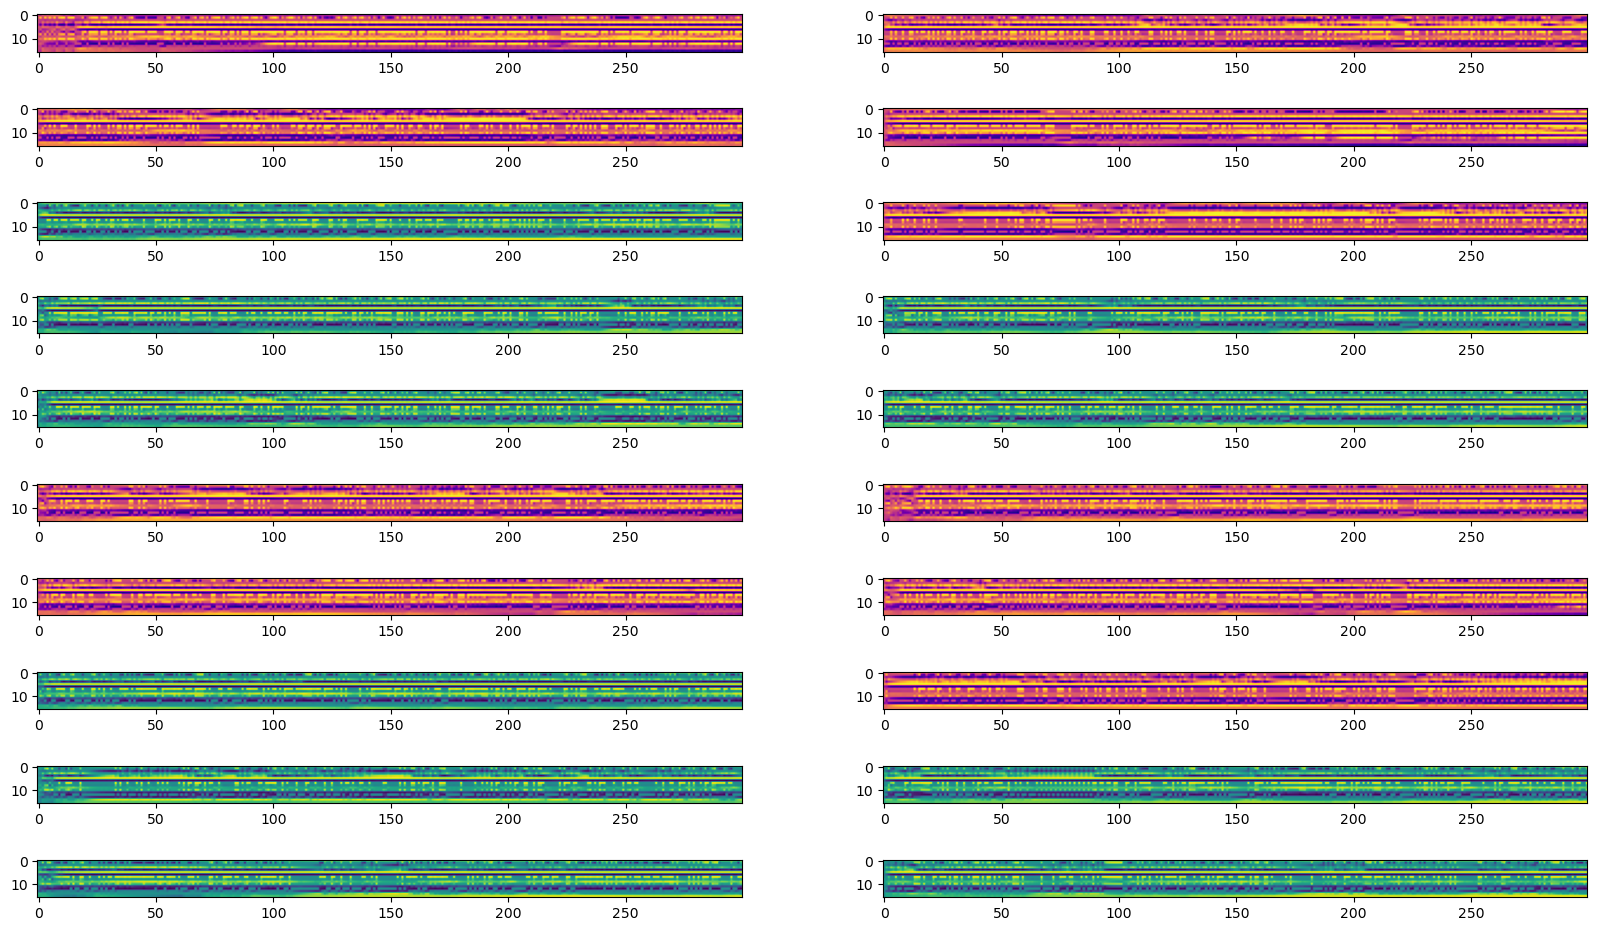

In [273]:
np_prediction
import matplotlib.pyplot as plt

label_color_maps = {0.: plt.get_cmap('viridis'), 1.: plt.get_cmap('plasma')}
fig, axes = plt.subplots(len(np_prediction), figsize=(20,12))
for ax, prediction, label in zip(axes.flatten(), np_prediction, test_labels):
    cmap = label_color_maps[float(label)]
    ax.imshow(prediction.T, cmap=cmap)
plt.tight_layout()

# Inspecting the output layer

A natural question when looking at these kinds of plots is "is there a correlation between the state and the class", and of course there is. For the simple model we've chosen with only a single dense layer going from the RNN state to the prediction we actually already have the coeficcient vector for linearly regressing the predicted class on this RNN state and we can inspect these weights to get an idea of how the models state is used.

Note that we're once again looking at the trained model (not `inspection_model`) since what we actually want to inspect is the weights of the final layer.

In [279]:
linear_regression_coefficients, linear_regression_intercept = model.layers[-1].get_weights()

We'll now plot this using a bar chart. It will clearly show us whether there are any units in the RNN state output which contributes more or less strongly to the prediction of whether the sequence is a promoter or not.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(len(linear_regression_coefficients))
y = linear_regression_coefficients.squeeze()
plt.bar(x, y)
plt.xlabel("RNN unit")
plt.ylabel("Linear regression coefficient")
plt.title("Weights of the output layer. Values above 0 contribute to\nthe positive prediction, below 0 to the negative.");

## Exercises

### Exercise 1
Change the size of the recurrent state to be smaller (e.g. 8 units).
- How does this affect the trainability and performance of the model?
- Does this change how spread out the coefficients of the last layer are?

### Exercise 2
The network trained is fairly small. Try increasing the number of LSTM layers and their dimension. What is the top performance you can achieve?

### Exercise 3
Change what species and whether you use a TATA dataset. Does the model perform worse when you switch to on of the nonTATA datasets?

## Language model pre-training

A common strategy in contemporary machine learning is to try to use datasets with large amounts of data to train a model. This model is then _transferred_ to a new problem and because of the pretraining on the larger set might be able to learn faster or better before overfitting. Here we will illustrate how we might be able to Language Modelling to first train a model on predicting what nucleotides are likely to follow in sequence, and then take the model which has learned this and train it on the classification task. The goal is to reduce the time it takes before the model starts learning the promoter classification task.

In [ ]:
from keras.utils import Sequence, pad_sequences
from collections import Counter # We will use a counter to keep track of which tokens are the most common
import numpy 


def character_tokenizer(text):
    return list(text)

class PromoterLMDataset(Sequence):
    def __init__(self, positive_sequences, batch_size, tokenizer=character_tokenizer, rng=None) -> None:
        super().__init__()
        if rng is None:
            rng = numpy.random.default_rng()
        self.rng = rng
        
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        
        self.positive_sequences = positive_sequences
        self.sequences = self.positive_sequences
        self.tokenized_data = [tokenizer(text) for text in self.sequences]
        
        self.token_encoding_map = {'<empty>': 0, 'A': 1, 'C': 2, 'G': 3, 'T': 4, 'N': 5}
        self.inverse_token_encoding_map = {i: token for token, i in self.token_encoding_map.items()}
        self.encoded_sequences = [self.encode_tokenized_text(text) for text in self.tokenized_data]
        
        self.n = len(self.encoded_sequences)//self.batch_size
        self.sequence_indices = np.arange(len(self.encoded_sequences))
        self.shuffle_examples()
        
    def shuffle_examples(self):
        self.rng.shuffle(self.sequence_indices)
        self.batches = np.reshape(self.sequence_indices[:self.n*self.batch_size], (self.n, -1))
    
    def __len__(self):
        return self.n
    
    def __getitem__(self, item):
        encoded_sequences_indices = self.batches[item]
        batch_sequences = [self.encoded_sequences[i] for i in encoded_sequences_indices]
        input_sequences = [encoded_sequence[:-1] for encoded_sequence in batch_sequences]        
        target_sequences = [encoded_sequence[1:] for encoded_sequence in batch_sequences]        
        pad_size = max(len(s) for s in input_sequences)
        padded_input_sequences = pad_sequences(input_sequences, pad_size, padding="post", value=0)
        padded_target_sequences = pad_sequences(target_sequences, pad_size, padding="post", value=0)
        
        return padded_input_sequences, padded_target_sequences
    
    def on_epoch_end(self):
        # We want to rearrange the order of samples so that we don't get the same batches all the time
        self.shuffle_examples()

    def encode_sequence(self, sequence):
        tokenized_text = self.tokenize_text(sequence)
        encoded_text = self.encode_tokenized_text(tokenized_text)
        return encoded_text
    
    def tokenize_text(self, sequence):
        return self.tokenzier(sequence)
    
    def encode_tokenized_text(self, tokenized_sequence):
        encoded_text = [self.token_encoding_map[c] for c in tokenized_sequence]
        return encoded_text

    def decode_encoded_text(self, encoded_text):
        decoded_text = [self.inverse_token_encoding_map[x] for x in encoded_text]
        return decoded_text

    def get_vocab_size(self):
        return len(self.token_encoding_map)

In [ ]:
lm_train_dataset = PromoterLMDataset(train_sequences, batch_size=BATCH_SIZE)
lm_dev_dataset = PromoterLMDataset(train_sequences, batch_size=BATCH_SIZE)

In [ ]:
lm_train_dataset[0]

In [ ]:
import keras.losses
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

#from tensorflow.keras.optimizer_v2.adam import Adam
# Alternatively:
from tensorflow.keras.optimizers import Adam

embedding_dimension = 4
rnn_dimension = 64
output_projection_dimension = 32

num_embeddings = lm_train_dataset.get_vocab_size()
lm_model = Sequential()
lm_model.add(Embedding(num_embeddings, embedding_dimension, mask_zero=True))
# Add LSTM layers; X.shape[1] refers to the number of columns in X which is the number of time steps, or window size
lm_model.add(LSTM(units=rnn_dimension, return_sequences=True, activation="tanh", unit_forget_bias=True, recurrent_dropout=0, dropout=0.2, use_bias=True))
# Add dense layer with activation for categorical output
lm_model.add(Dense(output_projection_dimension, activation="relu"))

# Here we use a single output which we will use for the binary cross entropy
lm_model.add(Dense(num_embeddings))

In [ ]:
learnRateVal = 0.01
opt = Adam(learning_rate=learnRateVal)
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
lm_model.compile(loss=loss_fn, optimizer=opt, metrics=["accuracy"])

callbacks = [
    #keras.callbacks.EarlyStopping(patience=20),
    keras.callbacks.ModelCheckpoint(filepath='lm_models/model.{epoch:02d}-{val_loss:.2f}.h5'),
    keras.callbacks.TensorBoard(log_dir='./lm_logs'),
]
Path('lm_models').mkdir(exist_ok=True)
lm_model.fit(lm_train_dataset, epochs=50, validation_data=lm_dev_dataset, callbacks=callbacks, verbose=1)

## Transferring the network
We will transfer what this network has learnt by removing the layers which took the recurrent state to predict the next token, disable the return of all states and finally add a new classification layer at the end to solve the binary classification task. We start by making a copy of the language modelling network so we can continue to train it if we would like.

We will start training the finetuned model with the embedding and recurrent layers frozen, so that the randomly initialized new Dense layers don't make noisy changes to them. We do this by setting the flag `layer.trainable = False`.

In [ ]:
finetuned_model = keras.models.clone_model(lm_model) 

# Cloning the model doesn't copy the weights, we need to set them explicitly
#learnRateVal = 0.01
#opt = Adam(learning_rate=learnRateVal)
#loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#finetuned_model.compile(loss=loss_fn, optimizer=opt, metrics=["accuracy"])
finetuned_model.set_weights(lm_model.get_weights())

In [ ]:
# Pop the last two dense layers
finetuned_model.pop()
finetuned_model.pop()

# Adjust the return_sequences of the LSTM layer and set the layers to not be trainable
for layer in finetuned_model.layers:
    layer.trainable = False
    if isinstance(layer, LSTM):
        layer.return_sequences = False

# Add layers for promoter classification
output_projection_dimension = 16
finetuned_model.add(Dense(output_projection_dimension, activation="relu"))
# Here we use a single output which we will use for the binary cross entropy
finetuned_model.add(Dense(1))


## Initial fine tuning

We make a first training run where the `Embedding` and `LSTM` layers are _frozen_, meaning that they will not be changed during training. The reason for this is to allow for the newly added, randomly initialized, layers to first adapt to the representations of the LSTM.

In [ ]:
learnRateVal = 0.001
opt = Adam(learning_rate=learnRateVal)
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
finetuned_model.compile(loss=loss_fn, optimizer=opt, metrics=["accuracy"])
finetuned_model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(patience=20),
    keras.callbacks.ModelCheckpoint(filepath='finetuned_models/model.{epoch:02d}-{val_loss:.2f}.h5'),
    keras.callbacks.TensorBoard(log_dir='./finetuned_logs'),
]
Path('models').mkdir(exist_ok=True)
finetuned_model.fit(training_dataset, epochs=10, validation_data=dev_dataset, callbacks=callbacks, verbose=1)

## Full fine tuning

Now that we've fine tuned the output layers for a while, let's fine tune the whole model. We start by setting all layers to trainable again.

In [ ]:
for layer in finetuned_model.layers:
    layer.trainable = True

In [ ]:
learnRateVal = 0.001
opt = Adam(learning_rate=learnRateVal)
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
finetuned_model.compile(loss=loss_fn, optimizer=opt, metrics=["accuracy"])
finetuned_model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(patience=20),
    keras.callbacks.ModelCheckpoint(filepath='finetuned_models/model.{epoch:02d}-{val_loss:.2f}.h5'),
    keras.callbacks.TensorBoard(log_dir='./finetuned_logs'),
]
Path('models').mkdir(exist_ok=True)
finetuned_model.fit(training_dataset, epochs=10, validation_data=dev_dataset, callbacks=callbacks, verbose=1)

## Exercises

### Exercise 3

Try to change the `lm_model` to have a higher capacity, like you did with the network without fine tuning. Are you able to now train larger networks faster and to better performance?